###Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Cited: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [1]:
#Import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv('./input/creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking The Target Class

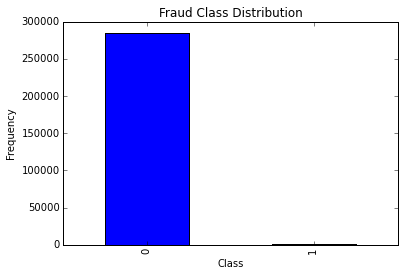

In [4]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

#### It can bee seen that the data is highly skewed

There are several ways to approach this classification problem taking into consideration this unbalance.
Collect more data? Nice strategy but not applicable in this case
Changing the performance metric: <br>
-  Use the confusion matrix to calculate Precision, Recall
-  F1score (weighted average of precision recall)
-  Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
-  ROC curves - calculates sensitivity/specificity ratio.
Resampling the dataset: <br>
-  Essentially this is a method that will process the data to have an approximate 50-50 ratio.
-  One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when we have little data)
-  Another is UNDER-sampling, which deletes instances from the over-represented class (better when we have lot's of data)

Approach
We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount).
We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logistic regression classifier.
We will evaluate the models by using some of the performance metrics mentioned above.
We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
We will finally perform classifications model using other classification algorithms.

####Setting our input and target variables + resampling.

In [5]:
#Normalize the Amount Column
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Amount', 'Time'], axis=1)
data.head()

/Users/TrungNguyen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


####Resampling
-  Under sampling
-  Over sampling
-  Synthetic Minority Over Sampling (SMOTE)

The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [6]:
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

In [7]:
# Number of samples in Class = 1
num_records_fraud = len(data[data['Class']==1])
fraud_indices = np.array(data[data['Class']==1].index)

In [8]:
# Indices of Class = 0
nofraud_indices = data[data['Class']==0].index

In [9]:
# Randomly select num_records_fraud from the Class = 0 to make the ratio 1/0 = 50/50
random_nofraud_indices = np.random.choice(nofraud_indices, num_records_fraud, replace=False)
random_nofraud_indices = np.array(random_nofraud_indices)

In [13]:
# Append the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_nofraud_indices])

In [14]:
# Under sampling dataset
under_sample_data = data.iloc[under_sample_indices, :]

In [15]:
len(under_sample_data)

984

In [16]:
len(fraud_indices) == len(random_nofraud_indices)

True

In [17]:
# X, y datasets
X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'Class']

In [22]:
# Display the ratio
print ("Percentage of normal transactions: ", 1.0*len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print ("Percentage of fraud transactions: ", 1.0*len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print ("Total data sample: ", len(under_sample_data))      

('Percentage of normal transactions: ', 0.5)
('Percentage of fraud transactions: ', 0.5)
('Total data sample: ', 984)


####Splitting data into train and test set. Ready for cross-validation

In [23]:
from sklearn.cross_validation import train_test_split

/Users/TrungNguyen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0 )
print ("Training sample size: ", len(X_train))
print ("Testing sample size: ", len(X_test))
print ("Total sample size: ", len(X_train) + len(X_test))

('Training sample size: ', 199364)
('Testing sample size: ', 85443)
('Total sample size: ', 284807)


In [28]:
# Under sampling dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, \
                                                                                                   y_undersample, \
                                                                                                   test_size=0.3, \
                                                                                                   random_state=0)
print ("Under sampling Training sample size: ", len(X_train_undersample))
print ("Under sampling Testing sample size: ", len(X_test_undersample))
print ("Under sampling sample size: ", len(X_train_undersample) + len(X_test_undersample))

('Under sampling Training sample size: ', 688)
('Under sampling Testing sample size: ', 296)
('Under sampling sample size: ', 984)


#### Logistic Regression - undersampled data

-  Accuracy = (TP+TN)/total
-  Precision = TP/(TP+FP)
-  Recall = TP/(TP+FN)

As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.

Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite.
We could even apply a cost function when having FN and FP with different weights for each type of error, but let's leave that aside for now.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, \
                            recall_score,classification_report 

In [34]:
range(1,2)

[1]

In [41]:
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(len(y_train_data),5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c
        
    

In [42]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
('C parameter: ', 0.01)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.9315068493150684)
('Iteration ', 2, ': recall score = ', 0.9178082191780822)
('Iteration ', 3, ': recall score = ', 1.0)
('Iteration ', 4, ': recall score = ', 0.9594594594594594)
('Iteration ', 5, ': recall score = ', 0.9545454545454546)

('Mean recall score ', 0.9526639964996129)

-------------------------------------------
('C parameter: ', 0.1)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.8356164383561644)
('Iteration ', 2, ': recall score = ', 0.863013698630137)
('Iteration ', 3, ': recall score = ', 0.9152542372881356)
('Iteration ', 4, ': recall score = ', 0.918918918918919)
('Iteration ', 5, ': recall score = ', 0.8787878787878788)

('Mean recall score ', 0.8823182343962468)

-------------------------------------------
('C parameter: ', 1)
-------------------------------------------

('

###Create a function to plot a fancy confusion matrix

In [43]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1 #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

('Recall metric in the testing dataset: ', 0)


/Users/TrungNguyen/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


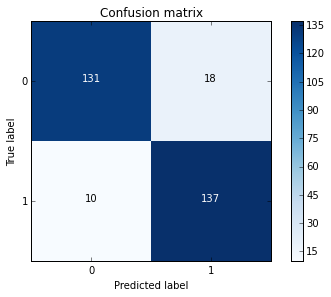

In [44]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

('Recall metric in the testing dataset: ', 0)


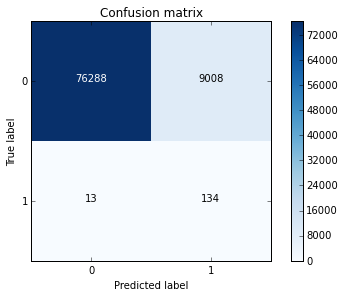

In [45]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

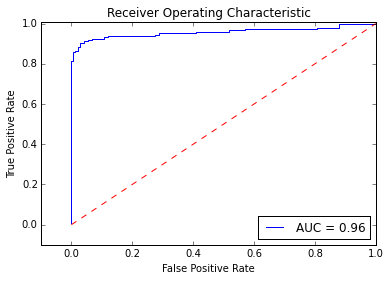

In [46]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
cnf_matrix

array([[76288,  9008],
       [   13,   134]])